In [1]:
#导入相关工具包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #黑体，没有此行会显示缺少字体的错误提示

In [2]:
data_train =pd.read_csv('train_public.csv')

In [3]:
data_train.shape

(10000, 39)

### 缺失值处理

In [4]:
data_train .isnull().sum()

loan_id                       0
user_id                       0
total_loan                    0
year_of_loan                  0
interest                      0
monthly_payment               0
class                         0
employer_type                 0
industry                      0
work_year                   622
house_exist                   0
censor_status                 0
issue_date                    0
use                           0
post_code                     0
region                        0
debt_loan_ratio               0
del_in_18month                0
scoring_low                   0
scoring_high                  0
known_outstanding_loan        0
known_dero                    0
pub_dero_bankrup              7
recircle_b                    0
recircle_u                    0
initial_list_status           0
app_type                      0
earlies_credit_mon            0
title                         0
policy_code                   0
f0                          498
f1      

In [5]:
#查找出数据中的对象特征和数值特征
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

In [6]:
#删除policy_code和loan_id
numerical_fea.remove('policy_code')
numerical_fea.remove('loan_id')

In [7]:
#按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())

In [8]:
numerical_fea.append('isDefault')

In [9]:
train=data_train.loc[:,numerical_fea]

In [10]:
train.shape

(10000, 31)

### 异常值处理

利用均方差检测异常值

In [11]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [12]:
for fea in numerical_fea:
    train = find_outliers_by_3segama(train,fea)
    print(train[fea+'_outliers'].value_counts())
    print(train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    10000
Name: user_id_outliers, dtype: int64
user_id_outliers
正常值    1683
Name: isDefault, dtype: int64
**********
正常值    9918
异常值      82
Name: total_loan_outliers, dtype: int64
total_loan_outliers
异常值      19
正常值    1664
Name: isDefault, dtype: int64
**********
正常值    10000
Name: year_of_loan_outliers, dtype: int64
year_of_loan_outliers
正常值    1683
Name: isDefault, dtype: int64
**********
正常值    9918
异常值      82
Name: interest_outliers, dtype: int64
interest_outliers
异常值      25
正常值    1658
Name: isDefault, dtype: int64
**********
正常值    9887
异常值     113
Name: monthly_payment_outliers, dtype: int64
monthly_payment_outliers
异常值      24
正常值    1659
Name: isDefault, dtype: int64
**********
正常值    9997
异常值       3
Name: house_exist_outliers, dtype: int64
house_exist_outliers
异常值       0
正常值    1683
Name: isDefault, dtype: int64
**********
正常值    10000
Name: censor_status_outliers, dtype: int64
censor_status_outliers
正常值    1683
Name: isDefault, dtype: int64
**********
正常值    9781
异常

In [13]:
#删除异常值
for fea in numerical_fea:
    train = train[train[fea+'_outliers']=='正常值']
    train = train.reset_index(drop=True)

In [14]:
data1=data_train.loc[data_train['user_id'].isin(train.user_id)]
data1.shape

(7843, 39)

### 时间格式处理

In [15]:
# 日期类型：issueDate，earliesCreditLine
# 转换为pandas中的日期类型
data1['issue_date'] = pd.to_datetime(data1['issue_date'])
# 提取多尺度特征
data1['issue_date_y'] = data1['issue_date'].dt.year
data1['issue_date_m'] = data1['issue_date'].dt.month
# 提取时间diff
# 设置初始的时间
base_time = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
# 转换为天为单位
data1['issue_date_diff'] = data1['issue_date'].apply(lambda x: x-base_time).dt.days
data1[['issue_date', 'issue_date_y', 'issue_date_m', 'issue_date_diff']]
data1.drop('issue_date', axis = 1, inplace = True)

In [16]:
#时间格式处理
df1=data1[[ 'user_id','issue_date_y', 'issue_date_m', 'issue_date_diff']]
df1=df1.reset_index(drop=True)
df1.shape

(7843, 4)

In [17]:
df1.head()

,user_id,issue_date_y,issue_date_m,issue_date_diff
0,240418,2016,10,3410
1,209360,2014,1,2406
2,239708,2015,7,2952
3,227483,2016,7,3318
4,247529,2013,11,2345


In [18]:
#df1.to_csv('Date_feature.csv')

### 类别特征处理

In [20]:
Of=data1.loc[:,['class','employer_type','industry','work_year','earlies_credit_mon']]
Of.to_csv('Object_feature.csv')

In [21]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit(data1['earlies_credit_mon'].values)
data1['earlies_credit_mon']=le.transform(data1['earlies_credit_mon'].values)

In [22]:
# 部分类别特征
cate_features = ['class','employer_type' ,'industry','work_year','earlies_credit_mon']
for f in cate_features:
    print(f, '类型数：', data_train[f].nunique())

class 类型数： 7
employer_type 类型数： 6
industry 类型数： 14
work_year 类型数： 11
earlies_credit_mon 类型数： 528


In [23]:
data1['class'] = data1['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

In [24]:
for data in [data1]:
    data = pd.get_dummies(data, columns=[ 'employer_type', 'industry', 'work_year'], drop_first=True)

In [25]:
#重新设置索引
data=data.reset_index(drop=True)
data.shape

(7843, 66)

### 数据分桶

In [26]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [27]:
len(numerical_serial_fea),len(numerical_noserial_fea)

(22, 9)

In [28]:
nvf=data.loc[:,numerical_serial_fea]
#nvf.to_csv('Num_Value_feature.csv')

In [29]:
ncf=data.loc[:,numerical_noserial_fea]
#ncf.to_csv('Num_Category_feature.csv')

In [30]:
numerical_serial_fea

['user_id',
 'total_loan',
 'interest',
 'monthly_payment',
 'use',
 'post_code',
 'region',
 'debt_loan_ratio',
 'del_in_18month',
 'scoring_low',
 'scoring_high',
 'known_outstanding_loan',
 'known_dero',
 'recircle_b',
 'recircle_u',
 'title',
 'f0',
 'f2',
 'f3',
 'f4',
 'early_return_amount',
 'early_return_amount_3mon']

In [31]:
data2=data1.loc[:,numerical_serial_fea]

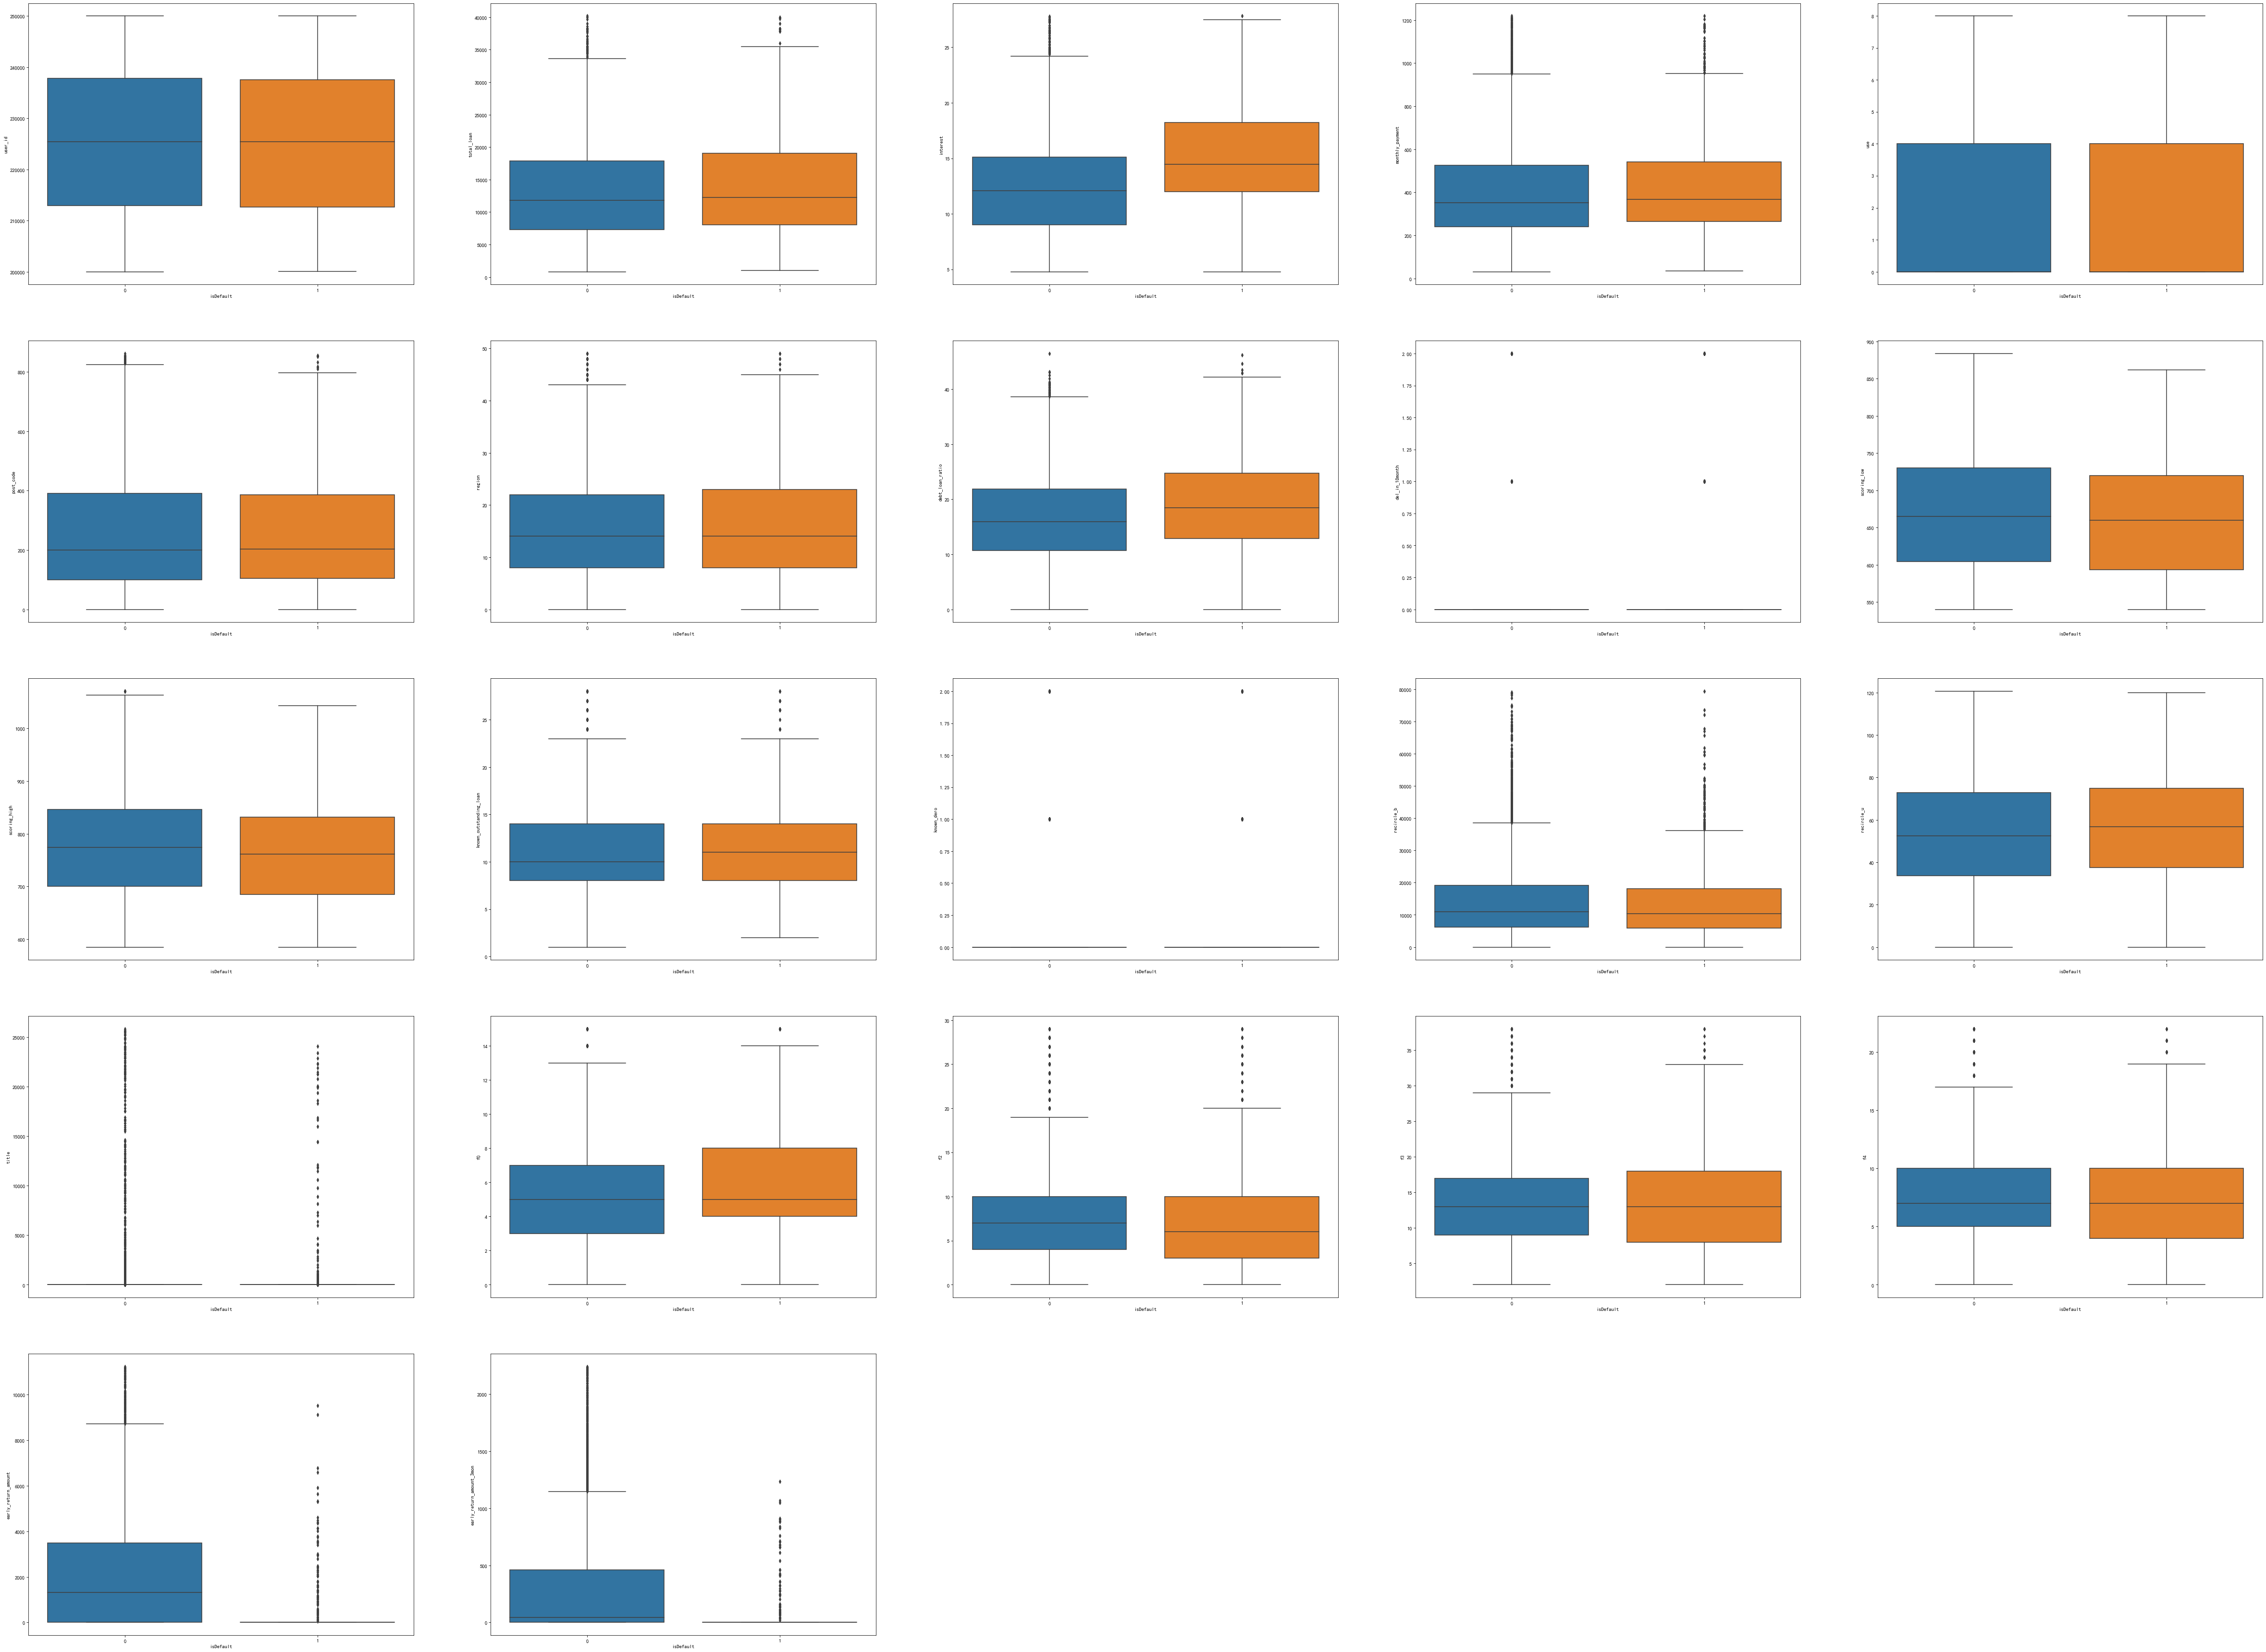

In [32]:
column = numerical_serial_fea  #列表头
fig = plt.figure(figsize=(80,60),dpi=75)    #指定绘图对象的宽度和高度
for i in range(len(numerical_serial_fea)):
    plt.subplot(5,5,i+1)    #7行8列子图
    sns.boxplot(x='isDefault',y=column[i],data=data1)    #箱型图
plt.show()

In [33]:
#显示所有行
#pd.set_option('display.max_rows',None)
data2_std=data2.std().sort_values(ascending=False)

In [55]:
#查看数值型的标准差
data_std=pd.DataFrame(data2_std,columns=['std']).head(10)
data_std
#data_std.to_csv('data_std.csv')

,std
user_id,14432.526290
recircle_b,11934.679179
total_loan,7967.015656
title,2884.367684
early_return_amount,2360.702928
early_return_amount_3mon,439.663121
monthly_payment,227.611738
post_code,200.342913
scoring_high,98.544358
scoring_low,76.653211


In [35]:
data2_index=['recircle_b','total_loan','title','early_return_amount']

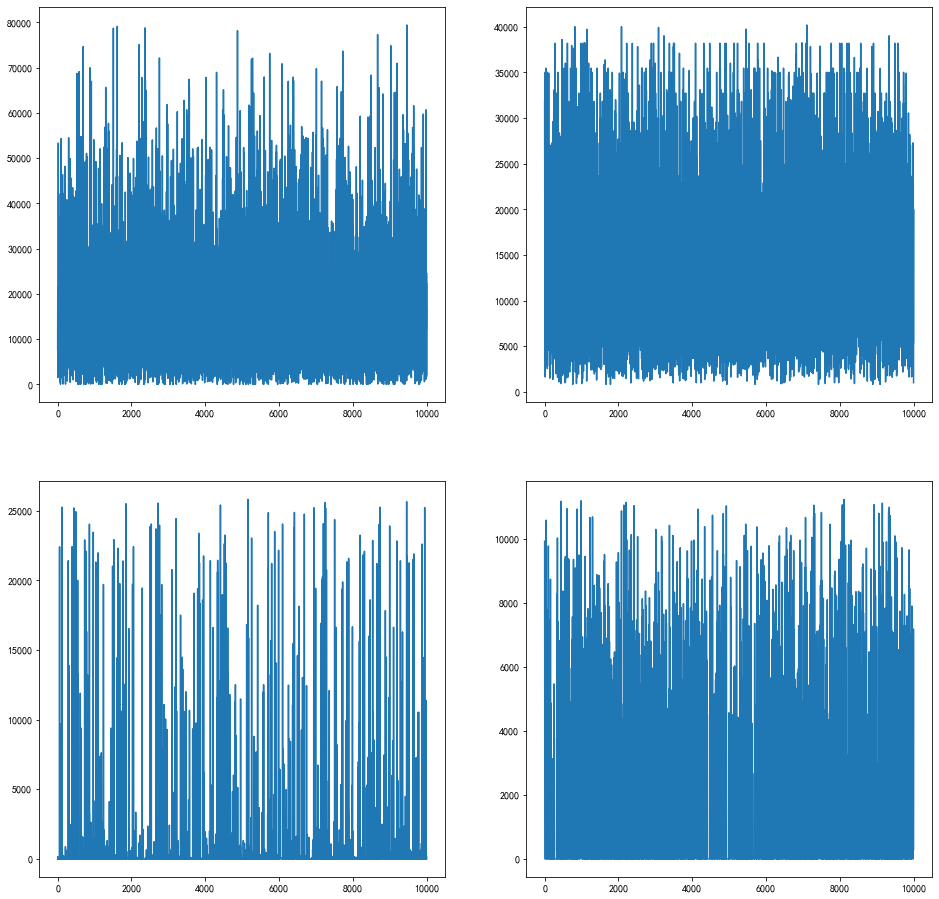

In [36]:
#对标准差大于1000的画图
dist_cols=2
dist_rows=2
plt.figure(figsize=(8*dist_cols,8*dist_rows))
i=1
for col in data2_index:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax=plt.plot(data2[col])
    i+=1
plt.show()

In [37]:
#对data2_index分箱处理
for i in data2_index:
    data2[i] = pd.qcut(data2[i], 10, labels=False,duplicates='drop')

In [38]:
#data2.to_csv('Break_barrel.csv')

### 特征交互

In [39]:
data3=data2.iloc[:,1:]

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
#多项式特征构造
poly = PolynomialFeatures(degree=3, include_bias=True)
poly.fit(data3)
X_poly = poly.transform(data3)
X_poly.shape

(7843, 2024)

In [42]:
data4=pd.DataFrame(X_poly,index=data2['user_id'])
data4=data4.rename_axis('user_id').reset_index()
data4.head()

,user_id,0,1,2,3,4,5,6,7,8,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,240418,1.0,9.0,11.466,1174.91,2.0,193.0,13.0,2.430000,0.0,...,64.0,96.0,0.0,144.0,0.0,0.0,216.0,0.0,0.0,0.0
1,209360,1.0,7.0,8.900,603.32,4.0,459.0,8.0,6.409091,0.0,...,6859.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,239708,1.0,7.0,4.788,602.30,0.0,157.0,8.0,9.204545,0.0,...,729.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,227483,1.0,6.0,12.790,470.31,0.0,38.0,21.0,15.578182,0.0,...,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,247529,1.0,9.0,10.637,899.15,0.0,258.0,8.0,15.807273,0.0,...,3375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#data4.to_csv('tzjh.csv')

In [44]:
#将数据合并
data5=pd.merge(df1,data,on='user_id')
data6=pd.merge(data5,data4,on='user_id')
data6.shape

(7843, 2093)

### 特征筛选

In [45]:
##方差筛选
from sklearn.feature_selection import VarianceThreshold
var_selector = VarianceThreshold(threshold = 1)#设置方差过滤阈值为1
var_selector.fit_transform(data6)
is_select = var_selector.get_support()#get_support函数返回方差＞阈值的布尔值序列
var_feature = data6.iloc[:,is_select]#根据布尔值序列取出各个特征所在列

In [46]:
isdefault = data6['isDefault'] #选中某列，将dataframe转series

Text(0.5, 1.0, '基于互信息的相关性筛选')

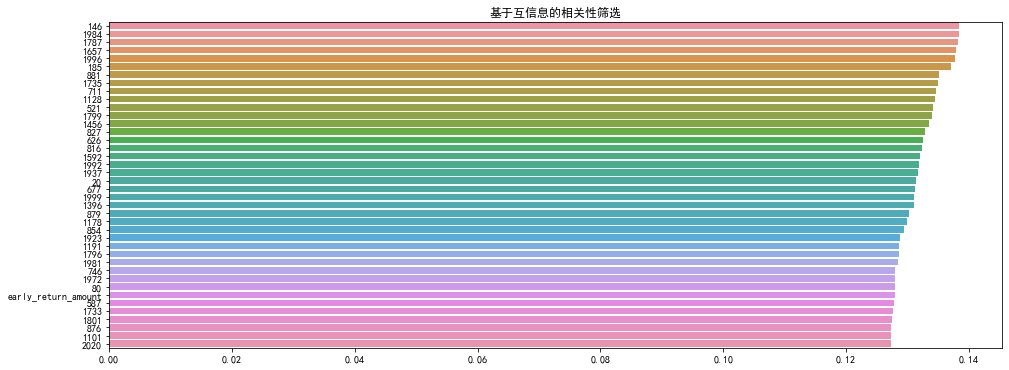

In [47]:
##相关性筛选
from sklearn.feature_selection import mutual_info_regression
mutualInfo = mutual_info_regression(var_feature,isdefault, discrete_features= False)
mutualInfo_select = pd.Series(data = mutualInfo , index = var_feature.columns).sort_values(ascending = False)
append_frame = var_feature#先复制dataFrame
append_frame.insert(len(var_feature.columns),isdefault.name,isdefault.values)#再添加一列
corr = append_frame.corr()
corr_series = pd.Series(data = corr.iloc[-1,:-1])
corr_sort = corr_series.abs().sort_values(ascending = False)
var_feature.drop('isDefault',axis = 1 , inplace = True)
plt.figure(figsize=(16,6))
sns.barplot(mutualInfo_select.values[:40], mutualInfo_select.index[:40], orient='h')
plt.title("基于互信息的相关性筛选")

In [48]:
columns1=mutualInfo_select.index[:30]
data7=data6.loc[:,columns1]
#data7.to_csv('相关性筛选30.csv')
#data7.to_csv('Filter_feature.csv')

Text(0.5, 1.0, '基于相关系数的相关性筛选')

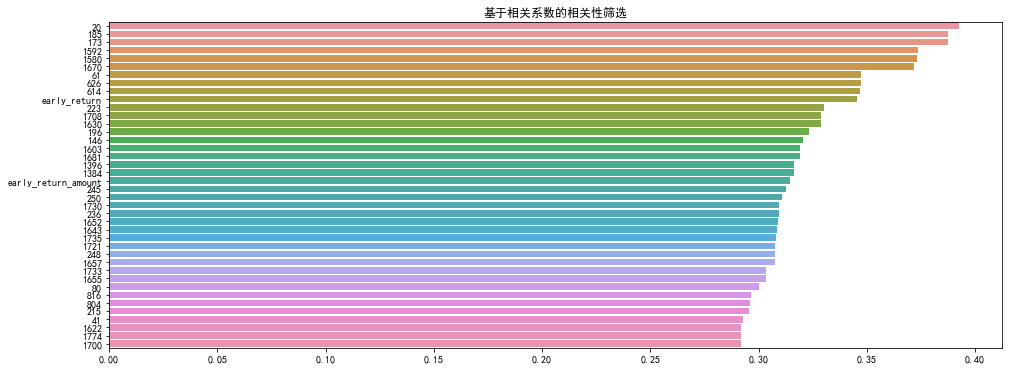

In [49]:
plt.figure(figsize=(16,6))
sns.barplot(corr_sort.values[:40], corr_sort.index[:40], orient='h')
plt.title("基于相关系数的相关性筛选")

In [50]:
data8=data6.loc[:,corr_sort.index[:30]]
#data8.to_csv('相关系数30.csv')

In [51]:
#查看相关性筛选和相关系数后前一百相同的特征
columns2=mutualInfo_select.index[:100]
columns3=corr_sort.index[:100]
columns_cols=[]
for col in columns2:
    if col in columns3:
        columns_cols.append(col)
    else:continue
len(columns_cols)

70

In [52]:
#得到最终的30个特征
col_z=columns_cols[0:30]
data9=data6.loc[:,col_z]
data9.shape
#data9.to_csv('zuizhong30.csv')

(7843, 30)